Streamlined (just essential working parts) of `_sandbox_homography.ipynb`.

In [1]:
import matplotlib.pyplot as plt
# Make plots interactive:
%matplotlib widget

In [2]:
import cv2
import numpy as np
import scipy.spatial.transform as transform

In [3]:
image_width, image_height = 2592, 1944  # actual image dimensions

In [4]:
# Choose the shape of the Top-Down Map (somewhat arbitrary):
map_width_mm = 150*10*2 # 150cm to either side
map_depth_mm = 420*10   # 420cm away from the rover (things are very squished beyond that)

In [5]:
from typing import Dict, Tuple, TypeAlias
PX_COORD: TypeAlias = Tuple[float, float]  # pixel space
UV_COORD: TypeAlias = Tuple[float, float]  # sensor space
XY_COORD: TypeAlias = Tuple[float, float]  # world space, ground plane

In [6]:
# World-coord measurements of the test grid in mm:
# FULL LIST OF ALL POINTS ON GRID:
grid_world_xs_mm = [
    [1530,      1535, 1531, 1533, 1526, 1526, 1526, 1523, 1520],
    [1225.5,    1228, 1226, 1224, 1221, 1220, 1222, 1222, 1218],
    [921,       922,  922,  917,  916,  914,  916,  915.5,911.5],
    [618,       617,  622,  612,  611,  609,  610,  610,  607],
    [                 315,  307.5,306,  305,  305            ]
]
grid_world_ys_mm = [
    [1220, 915, 609, 305, 0, -305, -609, -914],
    [1219, 913, 610, 304, 0, -305, -601, -904, -1219],
    [1218, 913, 610, 305, 0, -305, -601, -904, -1216],
    [1218, 922, 613, 305, 0, -305, -601, -904, -1217.5],
    [           610, 305, 0, -305 ,-609.5             ]
]

# ONLY POINTS WE COULD FIND SAMPLES FOR:
grid_world_xs_mm = [
    [922,  917,  916,  914,  916],
    [622,  612,  611,  609],
    [307.5, 306,  305]
]
grid_world_ys_mm = [
    [610, 305, 0, -305, -601],
    [613, 305, 0, -305],
    [305, 0, -305]
]

# Convert to a flattened list of point tuples:
grid_world_pts_mm = [
    (x,y)
    for xs_row, ys_row in zip(grid_world_xs_mm, grid_world_ys_mm)
    for x,y in zip(xs_row, ys_row)
]

# Measured coordinates from image in pixel space
# (pixel rows from top, pixel cols from left):
# **NOTE:** MUST BE IN SAME ORDER AS `grid_world_pts_mm` (row-wise from the top).
# **NOTE:** If you can't make out a coord in the image, delete (comment it out)
# from the `grid_world` entries:
grid_pixel_pts = [
    (741, 479), (741, 816), (729, 1320), (704, 1719), (680, 2233),
    (837, 225), (828, 704), (823, 1288), (792,1980),
    (1087,247), (1068, 1319), (1043, 2543)
]


In [7]:
# Generate ground truth:
from collections import OrderedDict
from typing import Tuple, TypeAlias
PX_COORD: TypeAlias = Tuple[float, float]  # pixel space (row, col)
UV_COORD: TypeAlias = Tuple[float, float]  # sensor space
XY_COORD: TypeAlias = Tuple[float, float]  # world space, ground plane

# Convert some known pairs (measured from cartesian image grid):
# *Also converts world coords from mm to cm (as expect by rest of code)
ground_truth: OrderedDict[PX_COORD, XY_COORD] = OrderedDict([
    (pixel, ((x/10), (y/10)))
    for (pixel, (x,y)) in zip(grid_pixel_pts, grid_world_pts_mm)
])

In [8]:
# Format Ground Truth into Format expected by Homography Solver:
# Source = Input Image Pixels (row, col):
src_pts = np.float32([ [p[0],p[1]] for p in ground_truth.keys() ])
# Destination = (X,Y) on Ground Plane in World Frame:
dst_pts = np.float32([ [p[0],p[1]] for p in ground_truth.values() ])

# Scale Ground Truth from [cm] to [mm] (for better integer resolution):
dst_pts *= 10
# Shift Ground Truth along crosstrack axis so no position in the map size are negative:
dst_pts[:, 1] += map_width_mm / 2

# Collect all source (pixel) and destination (world plane) points as a
# homogeneous matrices for use with Homography matrix:
src_mat = np.hstack(( src_pts, np.ones((src_pts.shape[0],1)) )).T
dst_mat = np.hstack(( dst_pts, np.ones((dst_pts.shape[0],1)) )).T
# XY Swap (to be compatible w/Homography):
src_mat[[1,0],:] = src_mat[[0,1],:]
dst_mat[[1,0],:] = dst_mat[[0,1],:]

In [9]:
# Homography Solver Settings:
from types import SimpleNamespace
opts = SimpleNamespace()
opts.max_iters: int = 1000 # the number of iterations to run RANSAC for
opts.inlier_tol: float = 1.0 # 2.0 # 'the tolerance value for considering a point to be an inlier

In [10]:
## 16720 Homography Code
import warnings
def computeH(x1, x2):
    """
    Compute the homography between two sets of points.

    Q2.2.1
    """
    Npts = x1.shape[0]
    Npts2 = x2.shape[0]
    assert Npts==Npts2, "Number of points in each list must be equal"
    
    A = np.zeros((Npts*2,9))
    
    for i in range(Npts):
        A[i*2:(i+1)*2, :] = np.array([
            [-x2[i,0], -x2[i,1], -1, 0, 0, 0, x1[i,0]*x2[i,0], x1[i,0]*x2[i,1], x1[i,0]],
            [0, 0, 0, -x2[i,0], -x2[i,1], -1, x1[i,1]*x2[i,0], x1[i,1]*x2[i,1], x1[i,1]],
        ])
        
        
    """
    SVD Approach (works fine, just slower than eig. Keeping in case of issue with eig.)
    _, s, Vh = np.linalg.svd(A, full_matrices=True)
    if s.shape[0] > 8 and abs(s[8]) > 1e-6:
        warnings.warn("Min singular value should be approximately zero.")
    V = Vh.T
    H2to1 = V[:,8] # Solution is eigenvector for smallest eigenvalue of A.T@A (last col of V)
    """
    D,V = np.linalg.eig(A.T@A)
    D = np.absolute(D) # only care about distance of e-values from 0
    i_min = np.argmin(D)
    if D[i_min] > 1e-3:
        warnings.warn("Min singular value should be approximately zero; it was {}.".format(D[i_min]))
    H2to1 = V[:,i_min]
    
    return H2to1.reshape((3,3))

def point_mean(x):
    """Compute mean of columns of given matrix x (faster than np.mean)."""
    Npts = x.shape[0]
    return np.sum(x[:, 0])/Npts, np.sum(x[:, 1])/Npts

def computeH_norm(x1, x2):
    """
    Compute the centroid of the points.
    
    Q2.2.2
    """
    #Shift the origin of the points to the centroid
    mean1 = point_mean(x1) # mean for each column (xvalues,yvalues) in x1
    mean2 = point_mean(x2) # mean for each column (xvalues,yvalues) in x2
    x1_centered = x1 - mean1
    x2_centered = x2 - mean2

	#Normalize the points so that the largest distance from the origin is equal to sqrt(2)
    max1 = np.max(np.absolute(x1_centered), axis=0)
    max2 = np.max(np.absolute(x2_centered), axis=0)
    if np.count_nonzero(max1==0) == 0:
        scale1 = 1.0 / max1 # scaling for each column (xvalues,yvalues) in x1
    else:
        warnings.warn("Zeros in maximum value for a column in x1. Ignoring scaling for that point collection.")
        scale1 = np.ones(max1.shape) # can't scale so don't. this likely won't generate the solution given this anomaly so this is fine.
    if np.count_nonzero(max2==0) == 0:
        scale2 = 1.0 / max2 # scaling for each column (xvalues,yvalues) in x2
    else:
        warnings.warn("Zeros in maximum value for a column in x2. Ignoring scaling for that point collection")
        scale2 = np.ones(max2.shape) # can't scale so don't. this likely won't generate the solution given this anomaly so this is fine.
    x1_normalized = x1_centered * scale1
    x2_normalized = x2_centered * scale2

	#Similarity transform 1
    T1 = np.array([
        [scale1[0], 0, -mean1[0]*scale1[0]],
        [0, scale1[1], -mean1[1]*scale1[1]],
        [0, 0, 1]
    ])

	#Similarity transform 2
    T2 = np.array([
        [scale2[0], 0, -mean2[0]*scale2[0]],
        [0, scale2[1], -mean2[1]*scale2[1]],
        [0, 0, 1]
    ])

	#Compute homography
    H2to1_norm = computeH(x1_normalized, x2_normalized)

	#Denormalization
    H2to1 = np.linalg.inv(T1) @ H2to1_norm @ T2

    return H2to1

def computeH_ransac(locs1, locs2, opts):
    """
    Compute the best fitting homography given a list of matching points.
    
    Q2.2.3
    """
    max_iters = opts.max_iters  # the number of iterations to run RANSAC for
    inlier_tol = opts.inlier_tol # the tolerance value for considering a point to be an inlier

    # Copy and swap columns (from (y,x) to (x,y)) per Piazza
    pts1 = np.copy(locs1)
    pts1[:,[1,0]] = pts1[:,[0,1]]
    pts2 = np.copy(locs2)
    pts2[:,[1,0]] = pts2[:,[0,1]]

    Npts = pts1.shape[0]
    Npts2 = pts2.shape[0]
    assert Npts == Npts2, "Both locs should contain same number of points."

    # Make homogeneous ahead of time for use in RANSAC inlier testing:
    pts_h1 = pts1.T
    pts_h1 = np.append(pts_h1, np.ones((1,Npts)), axis=0)
    pts_h2 = pts2.T
    pts_h2 = np.append(pts_h2, np.ones((1,Npts)), axis=0)

    # Count inliers in model given by homography H:
    def count_inliers(H):
        estimate = H@pts_h2
        # Rescale third element to rehomogenize estimate (account for "up to scale" equivalence):
        if np.count_nonzero(estimate[2,:]) == estimate.shape[1]:
            estimate = estimate / estimate[2,:]
        inliers = np.linalg.norm(pts_h1 - estimate, axis=0) < inlier_tol # True if inlier
        num_inliers = np.count_nonzero(inliers)
        return num_inliers, inliers

    count = 1
    bestH2to1 = None
    best_inliers = None # Boolean vector with True for inliers during best homography fit
    best_inlier_count = -1
    while count < max_iters:
        # Select randomly the minimum number of points to fix model (8 points = 4 correspondences):
        sample_idx = np.random.choice(Npts, 4)
        sample1 = pts1[sample_idx,:]
        sample2 = pts2[sample_idx,:]
        
        # Solve for model (H):
        H2to1 = computeH_norm(sample1, sample2)
        
        # Count inliers:
        num_inliers, inliers = count_inliers(H2to1)
        
        # If best homography, save the model and the inliers (to try to build a better model later):
        if num_inliers > best_inlier_count:
            bestH2to1 = H2to1
            best_inliers = inliers
            best_inlier_count = num_inliers
        
        # If all points are (somehow) inliers, woohoo! Terminate early.
        if num_inliers == Npts:
            #terminate early
            break

        count = count + 1
        
    # Rebuild model using all inliers from best fit:
    H2to1 = computeH_norm(pts1[best_inliers,:], pts2[best_inliers,:])
    num_inliers, inliers = count_inliers(H2to1)
    # Make sure it's actually an improvement; if so, keep:
    if num_inliers > best_inlier_count:
        bestH2to1 = H2to1
        best_inliers = inliers

    inliers = (best_inliers*1) # convert from Bool to Int vector (per spec)
    return bestH2to1, inliers

def compositeH(H2to1, template, img):
    """
    Create a composite image after warping the template image on top of the image using the homography
    """
    #Note that the homography we compute is from the image to the template;
    #x_template = H2to1*x_photo
    #For warping the template to the image, we need to invert it.
    H1to2 = np.linalg.inv(H2to1)
	
    #Create mask of same size as template
    mask = np.ones(template.shape)

    #Warp mask by appropriate homography
    warped_mask = cv2.warpPerspective(mask, H1to2, (img.shape[1],img.shape[0]))
    #Warp template by appropriate homography
    warped_template = cv2.warpPerspective(template, H1to2, (img.shape[1],img.shape[0]))
    
    #Use mask to combine the warped template and the image
    composite_img = img * (np.logical_not(warped_mask)) + warped_template
    
    return composite_img

In [11]:
ransac_trial_count = 50
# Run RANSAC a bunch (`ransac_trial_count`) of times and pick the one which minimizes the error to all points:
best_error_so_far = float('inf')
for i in range(ransac_trial_count):
    # Solve a Homography:
    H2to1, _ = computeH_ransac(src_pts, dst_pts, opts)
    H1to2 = np.linalg.inv(H2to1)
    # Compute error:
    # Apply homography to all source (pixel) points to create estimate:
    # (doing this in pixel->world space b/c that's what we care about)
    dst_mat_est = H1to2 @ src_mat
    # Normalize output:
    dst_mat_est /= dst_mat_est[-1,:]
    # Compare estimate:
    errors = np.linalg.norm(dst_mat - dst_mat_est, axis=0)
    error_mag = np.linalg.norm(errors)
    # Keep if best estimates of world points so far:
    if error_mag < best_error_so_far:
        best_error_so_far = error_mag
        bestH2to1 = H2to1
        bestH1to2 = H1to2
        print(f"{i} -> {error_mag}")

# Log the final matrices:
bestH1to2 = np.linalg.inv(bestH2to1)
bestH2to1, bestH1to2

/var/folders/44/s4c635957kj582ykvhndm9w00000gn/T/ipykernel_13771/1479757027.py:67: UserWarning: Zeros in maximum value for a column in x2. Ignoring scaling for that point collection
  warnings.warn("Zeros in maximum value for a column in x2. Ignoring scaling for that point collection")
/var/folders/44/s4c635957kj582ykvhndm9w00000gn/T/ipykernel_13771/1479757027.py:62: UserWarning: Zeros in maximum value for a column in x1. Ignoring scaling for that point collection.
  warnings.warn("Zeros in maximum value for a column in x1. Ignoring scaling for that point collection.")


0 -> 115.67526110872144
2 -> 115.6752611087202
10 -> 115.67526110872012
30 -> 115.67526110871927
38 -> 115.67526110871847


(array([[ 1.03770408e+00, -1.00824577e+00, -1.64049035e+03],
        [-7.41210506e-02, -3.66384109e-01, -9.44793649e+01],
        [-4.90662446e-05, -7.58066795e-04,  8.02616009e-03]]),
 array([[ 5.13043997e-01, -8.61257843e+00,  3.48021765e+03],
        [-3.59907783e-02,  4.96541193e-01, -1.51126162e+03],
        [-2.62924194e-04, -5.75312336e-03,  3.13025870e+00]]))

In [12]:
# Run some tests:
print("Pixel (r,c)  \tCalc. XY \t\t  Real XY\tError")
for px_coord, xy_coord in ground_truth.items():
    px, py = px_coord
    xy_est = bestH1to2 @ np.array([px_coord[1], px_coord[0],1]).reshape((3,1))
    # Normalize (and de-homogenize):
    xy_est = xy_est[[1,0], :] / xy_est[-1]
    # Shift est back to middle (restore negative values):
    xy_est[1] -= map_width_mm/2
    # Convert Est. to cm:
    xy_est /= 10

    # Compute Error and Display Results:
    xy_truth = np.array([*xy_coord]).reshape((2,1))
    diff = xy_truth-xy_est
    rmse = np.linalg.norm(diff) / np.sqrt(diff.size)
    p_error = rmse / np.linalg.norm(xy_truth)
    print(f"({int(px):4d},{int(py):4d}) -> ({xy_est[0,0]:.1f}, {xy_est[1,0]:.1f})\t v.\t ({xy_truth[0,0]:.1f}, {xy_truth[1,0]:.1f}) \t{p_error*100:.1f}%")

Pixel (r,c)  	Calc. XY 		  Real XY	Error
( 741, 479) -> (92.2, 61.0)	 v.	 (92.2, 61.0) 	0.0%
( 741, 816) -> (87.0, 34.3)	 v.	 (91.7, 30.5) 	4.4%
( 729,1320) -> (84.8, 0.3)	 v.	 (91.6, 0.0) 	5.2%
( 704,1719) -> (89.2, -26.0)	 v.	 (91.4, -30.5) 	3.7%
( 680,2233) -> (91.6, -60.1)	 v.	 (91.6, -60.1) 	0.0%
( 837, 225) -> (63.3, 57.1)	 v.	 (62.2, 61.3) 	3.5%
( 828, 704) -> (61.9, 30.9)	 v.	 (61.2, 30.5) 	0.8%
( 823,1288) -> (59.1, 1.7)	 v.	 (61.1, 0.0) 	3.0%
( 792,1980) -> (61.1, -30.6)	 v.	 (60.9, -30.5) 	0.2%
(1087, 247) -> (30.8, 30.5)	 v.	 (30.8, 30.5) 	0.0%
(1068,1319) -> (30.6, -0.0)	 v.	 (30.6, 0.0) 	0.0%
(1043,2543) -> (30.7, -31.4)	 v.	 (30.5, -30.5) 	1.5%


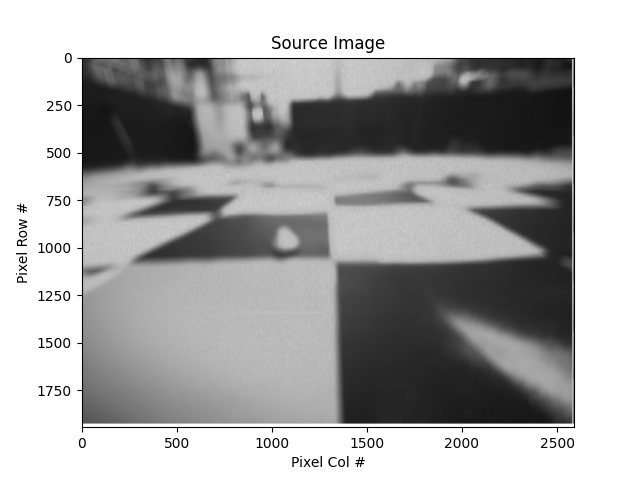

In [13]:
im_src = cv2.imread('/Users/connorcolombo/Documents/PKBACK/GitHub/CubeRoverPackage/Apps/GroundSoftware/out/image_file_decodings/img_img_EM4_MY_grid_homography_test_img_cam1_image6__01HGPF0YZX62QSB6AKY7W2NFGM__52324/img_img_EM4_MY_grid_homography_test_img_cam1_image6__01HGPF0YZX62QSB6AKY7W2NFGM__52324.image.median.adjusted.png')
im_src = cv2.resize(im_src, (image_width, image_height))
plt.figure()
plt.imshow(cv2.cvtColor(im_src, cv2.COLOR_BGR2RGB))
plt.title("Source Image")
plt.xlabel("Pixel Col #")
plt.ylabel("Pixel Row #")
plt.show(block=False)

/var/folders/44/s4c635957kj582ykvhndm9w00000gn/T/ipykernel_13771/1896649304.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels([str(l) for l in labels])


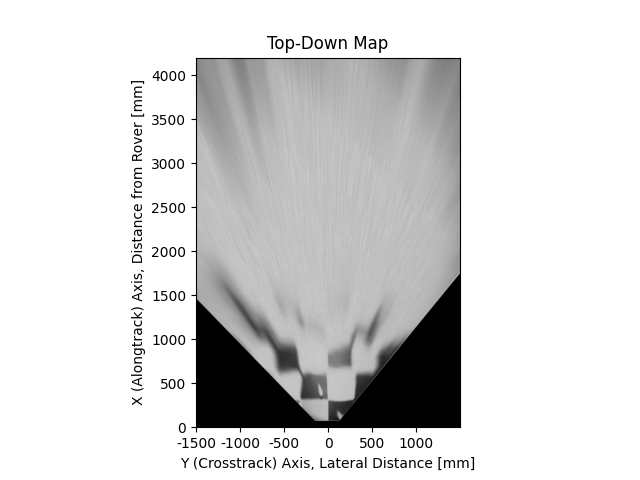

True

In [14]:
warped = cv2.warpPerspective(im_src, bestH1to2, (map_width_mm, map_depth_mm))
# image is flipped up/down and left/right.
# unflip LR here but leave UD flipped so we can handle that in the plot with a
# flipped axis (so the labels still have 0 being closest to the rover)
warped = np.fliplr(warped)
plt.figure()
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.gca().invert_yaxis()
plt.title("Top-Down Map")
plt.xlabel("Y (Crosstrack) Axis, Lateral Distance [mm]")
plt.ylabel("X (Alongtrack) Axis, Distance from Rover [mm]")

# Adjust X-Axis Tick labels so they represent reality
# (we had to shift everything by `map_width_mm` so no top-down columns would be
# negative and now we have to shift everything back):
axs = plt.gca()
labels = [item.get_text() for item in axs.get_xticklabels()]
# Replace unicode ticks '-' with ASCII ticks (so they can be parsed by int):
labels = [l.replace(u'\u2212', '-') for l in labels]
# Convert Labels to int & shift:
labels = [int(l)-map_width_mm//2 for l in labels]
# Convert back to text and apply:
axs.set_xticklabels([str(l) for l in labels])

plt.show(block=False)
# correct the up/down flip before saving:
warped = np.flipud(warped)
cv2.imwrite('./out/top_down_grid__1mm_per_px.png', warped)


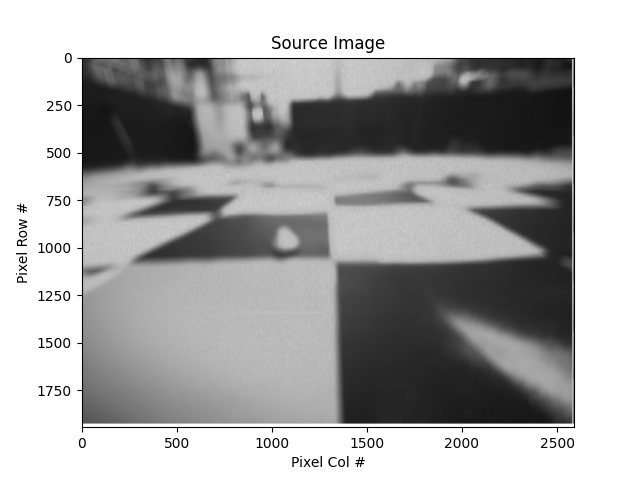

/var/folders/44/s4c635957kj582ykvhndm9w00000gn/T/ipykernel_13771/2649967510.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels([str(l) for l in labels])


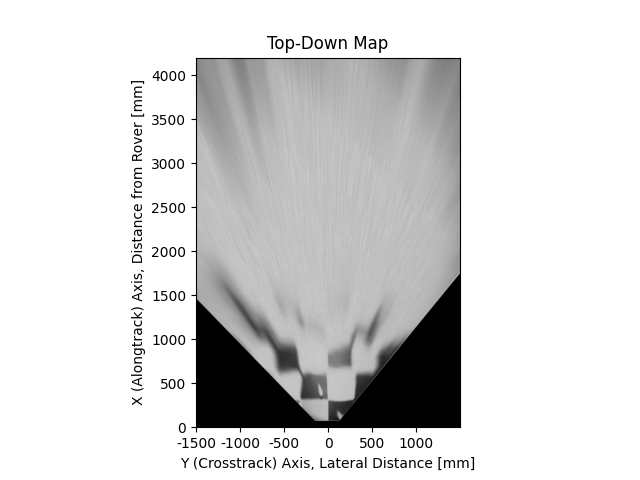

True

In [15]:
im_src2 = cv2.imread('/Users/connorcolombo/Documents/PKBACK/GitHub/CubeRoverPackage/Apps/GroundSoftware/out/image_file_decodings/img_img_EM4_MY_grid_homography_test_img_cam1_image6__01HGPF0YZX62QSB6AKY7W2NFGM__52324/img_img_EM4_MY_grid_homography_test_img_cam1_image6__01HGPF0YZX62QSB6AKY7W2NFGM__52324.image.median.adjusted.png')
im_src2 = cv2.resize(im_src2, (image_width, image_height))
plt.figure()
plt.imshow(cv2.cvtColor(im_src2, cv2.COLOR_BGR2RGB))
plt.title("Source Image")
plt.xlabel("Pixel Col #")
plt.ylabel("Pixel Row #")
plt.show(block=False)

warped2 = cv2.warpPerspective(im_src2, bestH1to2, (map_width_mm, map_depth_mm))
# image is flipped up/down and left/right.
# unflip LR here but leave UD flipped so we can handle that in the plot with a
# flipped axis (so the labels still have 0 being closest to the rover)
warped2 = np.fliplr(warped2)
plt.figure()
plt.imshow(cv2.cvtColor(warped2, cv2.COLOR_BGR2RGB))
plt.gca().invert_yaxis()
plt.title("Top-Down Map")
plt.xlabel("Y (Crosstrack) Axis, Lateral Distance [mm]")
plt.ylabel("X (Alongtrack) Axis, Distance from Rover [mm]")

# Adjust X-Axis Tick labels so they represent reality
# (we had to shift everything by `map_width_mm` so no top-down columns would be
# negative and now we have to shift everything back):
axs = plt.gca()
labels = [item.get_text() for item in axs.get_xticklabels()]
# Replace unicode ticks '-' with ASCII ticks (so they can be parsed by int):
labels = [l.replace(u'\u2212', '-') for l in labels]
# Convert Labels to int & shift:
labels = [int(l)-map_width_mm//2 for l in labels]
# Convert back to text and apply:
axs.set_xticklabels([str(l) for l in labels])

plt.show(block=False)
# correct the up/down flip before saving:
warped2 = np.flipud(warped2)
cv2.imwrite('./out/top_down_real__1mm_per_px.png', warped2)